In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

# Vision Transformer (ViT)

![](assets/attn.png)

In [3]:
class MultiHeadAtt(nn.Module):
    """Basic attention block
    
    This is a simplified version referenced from: 
    https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py#L178-L202
    """
    def __init__(self, d_model, head=8):
        super().__init__()
        
        self.d_head = d_model // head
        self.head = head
        
        # We don't want to create *head* instances of Linear class
        # so we just group it to single Linear that takes in *d_model* channels and returns *d_head* x *head* channels
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        nn.init.xavier_uniform_(self.W_q.weight)
        
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        nn.init.xavier_uniform_(self.W_k.weight)
        
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        nn.init.xavier_uniform_(self.W_v.weight)
        
        self.W_o = nn.Linear(d_model, d_model)
        nn.init.xavier_uniform_(self.W_o.weight)
        nn.init.zeros_(self.W_o.bias)
    
    def forward(self, x):
        """
        Args:
        - x: a B x N x C tensor
        
        Annotations:
        - B: batch size
        - N: number of token
        - C: number of channel
        """
        B, N, C = x.shape
        
        queries = self.W_q(x) # B x N x head*d_head
        keys = self.W_k(x)
        values = self.W_v(x)
        
        queries = queries.reshape(B, N, self.head, self.d_head).permute(0, 2, 1, 3) # B x head x N x d_head
        keys = keys.reshape(B, N, self.head, self.d_head).permute(0, 2, 1, 3)
        values = values.reshape(B, N, self.head, self.d_head).permute(0, 2, 1, 3)
        
        attn = (queries @ keys.transpose(-2, -1)) / self.d_head ** 0.5
        attn = F.softmax(attn, dim=-1) # B x head x N x N
        
        x = attn @ values # B x head x N x h_head
        x = x.transpose(1, 2) # B x N x head x h_head
        x = x.reshape(B, N, C) # B x N x head*h_head - Remind: d_model = C = head*h_head
        
        x = self.W_o(x)
        return x

In [4]:
# Test
module = MultiHeadAtt(256)
input_tensor = torch.ones((1, 16, 256))

output_tensor = module(input_tensor)
assert output_tensor.shape == (1, 16, 256)

![](assets/vit.png)

In [5]:
class FFN(nn.Module):
    """MLP or Feed forward network used in attention blocks"""
    def __init__(self, d_in_out, d_hidden):
        super().__init__()
        self.fc1 = nn.Linear(d_in_out, d_hidden)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.normal_(self.fc1.bias, std=1e-6)
        
        self.fc2 = nn.Linear(d_hidden, d_in_out)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.normal_(self.fc2.bias, std=1e-6)
    
    def forward(self, x):
        """
        Args:
        - x: a B x N x C tensor
        
        Annotations:
        - B: batch size
        - N: number of token
        - C: number of channel
        """
        x = F.gelu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
class TransformerEncoder(nn.Module):
    """Basic building block of ViT"""
    def __init__(self, d_model, head, d_ff_hid):
        super().__init__()
        
        self.input_norm = nn.LayerNorm(d_model)
        self.multi_attn = MultiHeadAtt(d_model, head)
        
        self.ff_norm = nn.LayerNorm(d_model)
        self.ff = FFN(d_model, d_ff_hid)
    
    def forward(self, x):
        """
        Args:
        - x: a B x N x C tensor
        
        Annotations:
        - B: batch size
        - N: number of token
        - C: number of channel
        """
        x_res = x
        x = self.input_norm(x)
        z = self.multi_attn(x) + x_res
        
        z_res = z
        z = self.ff_norm(z)
        z = self.ff(z) + z_res
        
        return z

In [49]:
class PatchEmbed(nn.Module):
    """A layer that splits image into patches and using a CNN to compute embedding feature of each patch"""
    def __init__(self, img_size, patch_size, img_c, d_model):
        super().__init__()
        
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)
        self.patch_size = patch_size if isinstance(patch_size, tuple) else (patch_size, patch_size)
        
        self.grid_size = (self.img_size[0] // self.patch_size[0], self.img_size[1] // self.patch_size[1])
        self.num_patches = self.grid_size[0] * self.grid_size[1]
        
        self.conv = nn.Conv2d(img_c, d_model, kernel_size=self.patch_size, stride=patch_size)
    
    def forward(self, x):
        """
        Args:
        - x: a B x C x H x W image tensor
        
        Annotations:
        - B: batch size
        - C: number of channel
        - H: height
        - W: width
        """
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        
        x = self.conv(x) # B x d_model x grid_H x grid_W
        x = torch.flatten(x, 2) # B x d_model x N
        x = x.transpose(1, 2) # B x N x d_model
        
        return x        

In [8]:
# Test
module = PatchEmbed(img_size=224, patch_size=16, img_c=3, d_model=256)
input_tensor = torch.ones((1, 3, 224, 224))

output_tensor = module(input_tensor)
assert output_tensor.shape == (1, 14 * 14, 256)

In [9]:
class ViT(nn.Module):
    """A skeleton of a typical ViT model"""
    def __init__(self, img_size, patch_size, img_c, d_model, num_class, encoders):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        
        self.patch_embeder = PatchEmbed(img_size, patch_size, img_c, d_model)
        
        num_patches = self.patch_embeder.num_patches
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, d_model))
        
        self.encoders = encoders
        self.mlp_head = nn.Linear(d_model, num_class)
        self.cls_morm = nn.LayerNorm(num_class)
    
    def forward(self, x):
        """
        Args:
        - x: a B x C x H x W image tensor
        
        Annotations:
        - B: batch size
        - C: number of channel
        - H: height
        - W: width
        """
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x_embed = self.patch_embeder(x)
        x_embed = torch.cat([cls_token, x_embed], dim=1)
        x_embed = x_embed + self.pos_embed
        
        x_transformed = self.encoders(x_embed)
        cls_transformed_token = x_transformed[:, 0, :] 
        cls_logits = self.mlp_head(cls_transformed_token)
        cls_logits = self.cls_morm(cls_logits)
        return cls_logits

In [10]:
# ViT variants -- ViT-B/16
n_class = 10
n_layer = 12
d_model = 768
n_head = 12
mlp_hidden = 3072

vit_encoder = nn.Sequential(*[TransformerEncoder(d_model=d_model, head=n_head, d_ff_hid=mlp_hidden) for i in range(n_layer)])
vit_b = ViT(img_size=224, patch_size=16, img_c=3, d_model=d_model, num_class=n_class, encoders=vit_encoder)

input_tensor = torch.ones((1, 3, 224, 224))

output_tensor = vit_b(input_tensor)
assert output_tensor.shape == (1, n_class), output_tensor.shape
summary(vit_b, input_size=(3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
        PatchEmbed-2             [-1, 196, 768]               0
         LayerNorm-3             [-1, 197, 768]           1,536
            Linear-4             [-1, 197, 768]         589,824
            Linear-5             [-1, 197, 768]         589,824
            Linear-6             [-1, 197, 768]         589,824
            Linear-7             [-1, 197, 768]         590,592
      MultiHeadAtt-8             [-1, 197, 768]               0
         LayerNorm-9             [-1, 197, 768]           1,536
           Linear-10            [-1, 197, 3072]       2,362,368
           Linear-11             [-1, 197, 768]       2,360,064
              FFN-12             [-1, 197, 768]               0
TransformerEncoder-13             [-1, 197, 768]               0
        LayerNorm-14             [-1, 

In [11]:
# ViT variants -- ViT-L/16
n_class = 10
n_layer = 24
d_model = 1024
n_head = 16
mlp_hidden = 4096

vit_encoder = nn.Sequential(*[TransformerEncoder(d_model=d_model, head=n_head, d_ff_hid=mlp_hidden) for i in range(n_layer)])
vit_l = ViT(img_size=224, patch_size=16, img_c=3, d_model=d_model, num_class=n_class, encoders=vit_encoder)

input_tensor = torch.ones((1, 3, 224, 224))

output_tensor = vit_l(input_tensor)
assert output_tensor.shape == (1, n_class), output_tensor.shape
summary(vit_l, input_size=(3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 1024, 14, 14]         787,456
        PatchEmbed-2            [-1, 196, 1024]               0
         LayerNorm-3            [-1, 197, 1024]           2,048
            Linear-4            [-1, 197, 1024]       1,048,576
            Linear-5            [-1, 197, 1024]       1,048,576
            Linear-6            [-1, 197, 1024]       1,048,576
            Linear-7            [-1, 197, 1024]       1,049,600
      MultiHeadAtt-8            [-1, 197, 1024]               0
         LayerNorm-9            [-1, 197, 1024]           2,048
           Linear-10            [-1, 197, 4096]       4,198,400
           Linear-11            [-1, 197, 1024]       4,195,328
              FFN-12            [-1, 197, 1024]               0
TransformerEncoder-13            [-1, 197, 1024]               0
        LayerNorm-14            [-1, 1

In [12]:
# ViT variants -- ViT-H/16
n_class = 10
n_layer = 32
d_model = 1280
n_head = 16
mlp_hidden = 5120

vit_encoder = nn.Sequential(*[TransformerEncoder(d_model=d_model, head=n_head, d_ff_hid=mlp_hidden) for i in range(n_layer)])
vit_h = ViT(img_size=224, patch_size=16, img_c=3, d_model=d_model, num_class=n_class, encoders=vit_encoder)

input_tensor = torch.ones((1, 3, 224, 224))

output_tensor = vit_h(input_tensor)
assert output_tensor.shape == (1, n_class), output_tensor.shape
summary(vit_h, input_size=(3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 1280, 14, 14]         984,320
        PatchEmbed-2            [-1, 196, 1280]               0
         LayerNorm-3            [-1, 197, 1280]           2,560
            Linear-4            [-1, 197, 1280]       1,638,400
            Linear-5            [-1, 197, 1280]       1,638,400
            Linear-6            [-1, 197, 1280]       1,638,400
            Linear-7            [-1, 197, 1280]       1,639,680
      MultiHeadAtt-8            [-1, 197, 1280]               0
         LayerNorm-9            [-1, 197, 1280]           2,560
           Linear-10            [-1, 197, 5120]       6,558,720
           Linear-11            [-1, 197, 1280]       6,554,880
              FFN-12            [-1, 197, 1280]               0
TransformerEncoder-13            [-1, 197, 1280]               0
        LayerNorm-14            [-1, 1

In [36]:
class EfficientMultiHeadAtt(nn.Module):
    """Efficient Attention block
    """
    def __init__(self, d_model, head=8, sr_ratio=1):
        super().__init__()
        
        self.d_head = d_model // head
        self.head = head
        self.sr_ratio = sr_ratio
        
        if self.sr_ratio > 1:
            self.sr_mlp = nn.Linear(d_model * sr_ratio, d_model)
        
        
        # We don't want to create *head* instances of Linear class
        # so we just group it to single Linear that takes in *d_model* channels and returns *d_head* x *head* channels
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        nn.init.xavier_uniform_(self.W_q.weight)
        
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        nn.init.xavier_uniform_(self.W_k.weight)
        
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        nn.init.xavier_uniform_(self.W_v.weight)
        
        self.W_o = nn.Linear(d_model, d_model)
        nn.init.xavier_uniform_(self.W_o.weight)
        nn.init.zeros_(self.W_o.bias)
    
    def forward(self, x):
        """
        Args:
        - x: a B x N x C tensor
        
        Annotations:
        - B: batch size
        - N: number of token
        - C: number of channel
        """
        B, N, C = x.shape
        
        reduced_kv_length = N//self.sr_ratio
        if self.sr_ratio > 1:
            x_kv = x.reshape(B, reduced_kv_length, C*self.sr_ratio)
            x_kv = self.sr_mlp(x_kv)
        
        queries = self.W_q(x) # B x N x head*d_head
        keys = self.W_k(x_kv)
        values = self.W_v(x_kv)
        
        queries = queries.reshape(B, N, self.head, self.d_head).permute(0, 2, 1, 3) # B x head x N x d_head
        keys = keys.reshape(B, reduced_kv_length, self.head, self.d_head).permute(0, 2, 1, 3)
        values = values.reshape(B, reduced_kv_length, self.head, self.d_head).permute(0, 2, 1, 3)
        
        attn = (queries @ keys.transpose(-2, -1)) / self.d_head ** 0.5
        attn = F.softmax(attn, dim=-1) # B x head x N x N
        
        x = attn @ values # B x head x N x h_head
        x = x.transpose(1, 2) # B x N x head x h_head
        x = x.reshape(B, N, C) # B x N x head*h_head - Remind: d_model = C = head*h_head
        
        x = self.W_o(x)
        return x

In [44]:
import time

eff_attn = EfficientMultiHeadAtt(256, 8, 4)
attn = MultiHeadAtt(256, 8)

eff_list = []
attn_list = []

for s in range(20):
    x = torch.randn(size=(1, 512 * (s+1), 256))
    start = time.time()
    eff_attn(x)
    end = time.time()

    eff_time = end - start
    eff_list.append(eff_time)

    start = time.time()
    attn(x)
    end = time.time()

    attn_time = end - start
    attn_list.append(attn_time)

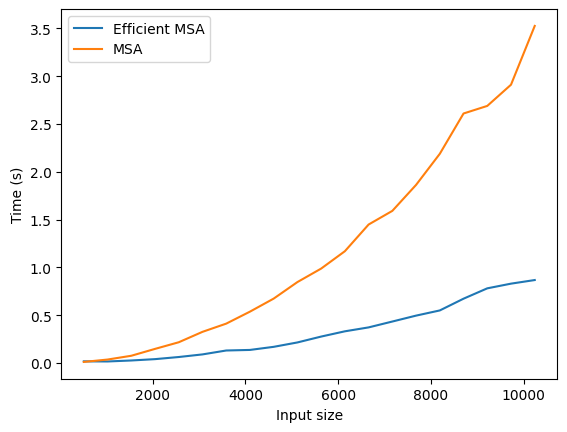

In [48]:
import matplotlib.pyplot as plt

xs = [512*(i+1) for i in range(20)]
plt.plot(xs, eff_list, label="Efficient MSA")
plt.plot(xs, attn_list, label="MSA")
plt.ylabel("Time (s)")
plt.xlabel("Input size")
plt.legend()
plt.show()